# Assignment 1 - Unsupervised learning
### Sanna Hartman Sellæg, Nima Salihzada, Tarjei Åkre Reite


This assignment explores a data set with customer data, and attempts to create clusters in the data that can reveal interesting information about different customer profiles.

#### Contents
0. Load data and imports
1. Data preparation
2. Choosing number of clusters
3. Train k-means models
4. Analyze clusters
5. Profiling
6. Dimensionality reduction

### 0. Load data and imports

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from kneed import KneeLocator


df = pd.read_csv('customer_data_large.csv')

### 1. Data preparation

Checking for missing data.

In [3]:
missing_values = df.isnull().sum()
question_mark_values = (df == '?').sum()

if missing_values.sum() > 0 or question_mark_values.sum() > 0:
    print("Missing or invalid values found.")
else:
    print("No missing or invalid values found.")

No missing or invalid values found.


Apply a scaler to the data.

In [4]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

### 2. Choosing number of clusters

Finding the correct number of clusters can be challenging, and to it requires evaluation metrics that do not need labeled data. For this assignment, the following methods will be examined (https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation):
1. SSE - Sum of Squared Error
2. Silhouette score
3. Calinski-Harabasz Index
4. Davies-Bouldin Index

First, try with several different values for k to find out which one(s) are best.

In [5]:
number_of_k_to_test = 20

sse = []
silhouette_scores = []
calinski_harabasz = []
davies_bouldin = []
for i in range(2, number_of_k_to_test):
    km = KMeans(n_clusters=i, random_state=19)
    km.fit(df_scaled)
    sse.append(km.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, km.labels_))
    calinski_harabasz.append(calinski_harabasz_score(df_scaled, km.labels_))
    davies_bouldin.append(davies_bouldin_score(df_scaled, km.labels_))

The Sum of Squared Error (sse) for each k is then plotted.

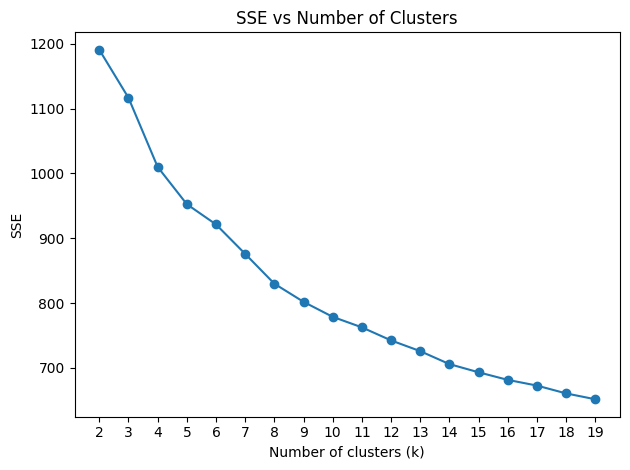

In [6]:
k_values = list(range(2, number_of_k_to_test))

plt.figure()
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.title('SSE vs Number of Clusters')
plt.xticks(k_values)
plt.tight_layout()
plt.show()



By looking at the plot of the errors against the number of clusters, the elbow method can be applied. This involves looking for the point where the rate of improvement starts to slow down when adding more clusters, which can look like the elbow of an arm.

Visually, it seems like the elbow might be somewhere between 7-10 clusters.

Alternatively, an imported library, kneed, has ha function that finds the elbow point. Since this function returns 8, that could indicate that 7-10 clusters was a good estimate.

In [7]:
knee_locator = KneeLocator(range(2, number_of_k_to_test), sse, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee

print(f"The optimal number of clusters is: {optimal_k}")

The optimal number of clusters is: 8


Next we plot the silhouette coefficients, where a higher score means that the model has better defined clusters.

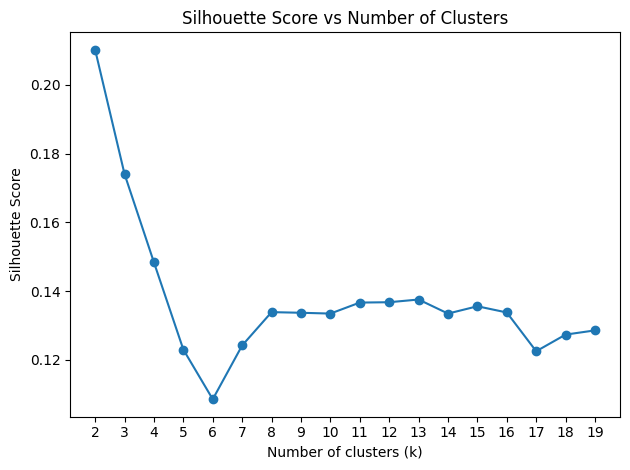

In [8]:
plt.figure()
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.xticks(k_values)
plt.tight_layout()
plt.show()

Based on the silhouette coefficients, it looks like the clarity of the clusters stabilize somewhat on the values between 8 and 16. 

Now the Calinski-Harabasz Index values are plottet.

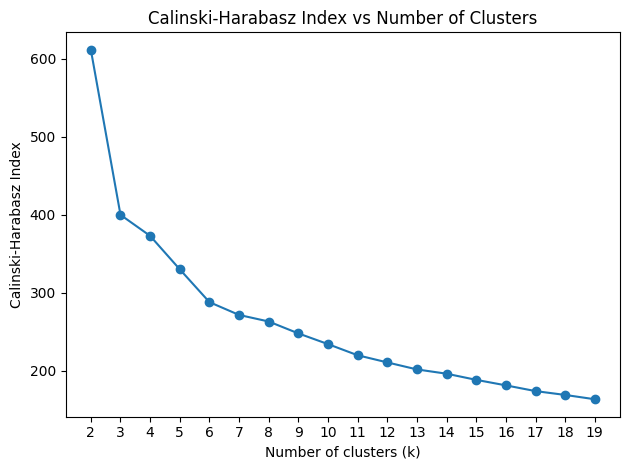

In [9]:
plt.figure()
plt.plot(k_values, calinski_harabasz, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index vs Number of Clusters')
plt.xticks(k_values)
plt.tight_layout()
plt.show()

It is hard to read anything conclusive from the Calinski-Harabasz values. Typically, higher values mean that the clusters are dense and well separated. It seems like adding more clusters do not improve neither the density or the separation.

Finally, the Davies‑Bouldin Index values:

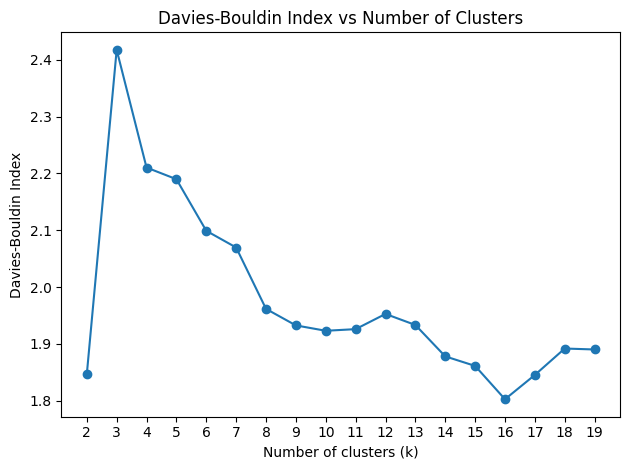

In [10]:
plt.figure()
plt.plot(k_values, davies_bouldin, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.xticks(k_values)
plt.tight_layout()
plt.show()

The Davies-Bouldin values are lower the better the cluster partition is. There seems to be a local minimum between 8 and 12, before the values go even lower at 16.

#### Summary of results

Four metrics have been used to evaluate how many clusters should be included in the k-means model. A SSE approach indicated that a value around 7-10 could be a good pick, which was further backed up by the silhouette scores, that showed that values between 8 and 16 could be fairly well considerations. Then, not much was learned from the Calinsi-Harabasz scores, but the Davies-Bouldin scores further indicated that a value around 8 clusters could be a good pick.
It should be noted that some numbers of clusters gave even better scores in some of the metrics, like 16 in the Davies-Bouldin metrics, but it is probably not desirable to continue with such a high number of clusters. The lowest number of clusters that seem to give sensible scores look like 8-10.

##### Averaging out randomness in results

As a side note it is useful to consider the fact that the random seed that was chosen (19) could be a statistical outlier, and that the nature of the data in reality is quite different. To explore this, we wrote code that averaged out fifty different random states to see how the results changed.

In [11]:
number_of_k_to_test = 20

sse = []
silhouette_scores = []
calinski_harabasz = []
davies_bouldin = []
for i in range(2, number_of_k_to_test):
    sse_sum = 0
    silhouette_sum = 0
    calinski_sum = 0
    davies_sum = 0
    for r in range(50): # 50 random states
        km = KMeans(n_clusters=i, random_state=r)
        km.fit(df_scaled)
        sse_sum += km.inertia_
        silhouette_sum += silhouette_score(df_scaled, km.labels_)
        calinski_sum += calinski_harabasz_score(df_scaled, km.labels_)
        davies_sum += davies_bouldin_score(df_scaled, km.labels_)
    sse.append(sse_sum / 50)
    silhouette_scores.append(silhouette_sum / 50)
    calinski_harabasz.append(calinski_sum / 50)
    davies_bouldin.append(davies_sum / 50)

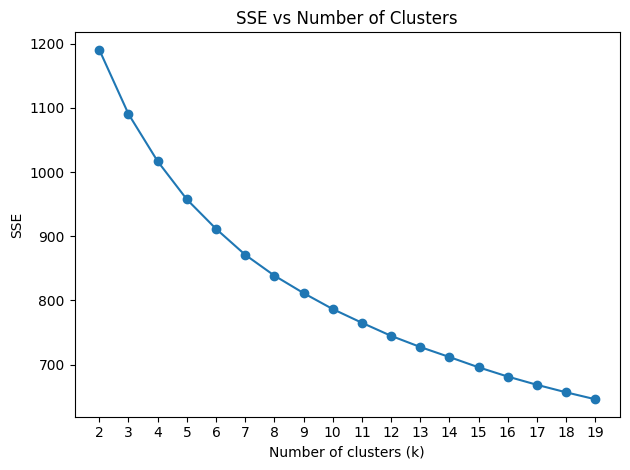

In [12]:
k_values = list(range(2, number_of_k_to_test))

plt.figure()
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.title('SSE vs Number of Clusters')
plt.xticks(k_values)
plt.tight_layout()
plt.show()

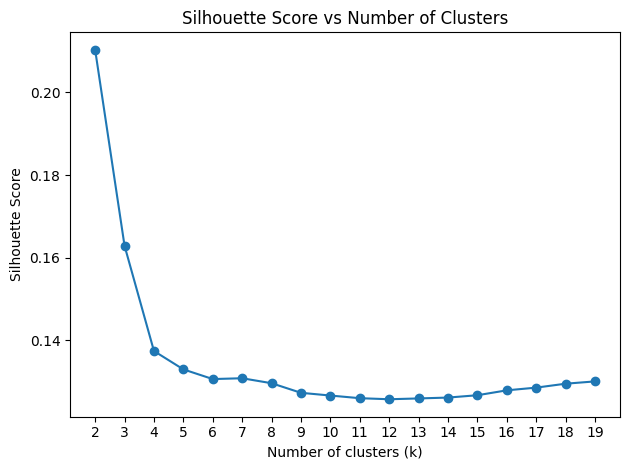

In [13]:
plt.figure()
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.xticks(k_values)
plt.tight_layout()
plt.show()

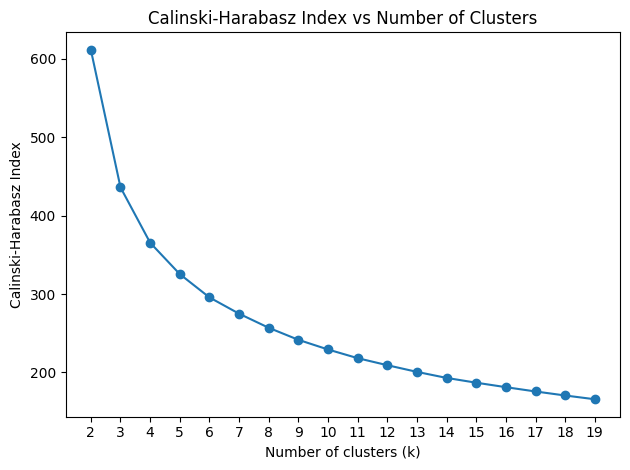

In [14]:
plt.figure()
plt.plot(k_values, calinski_harabasz, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index vs Number of Clusters')
plt.xticks(k_values)
plt.tight_layout()
plt.show()

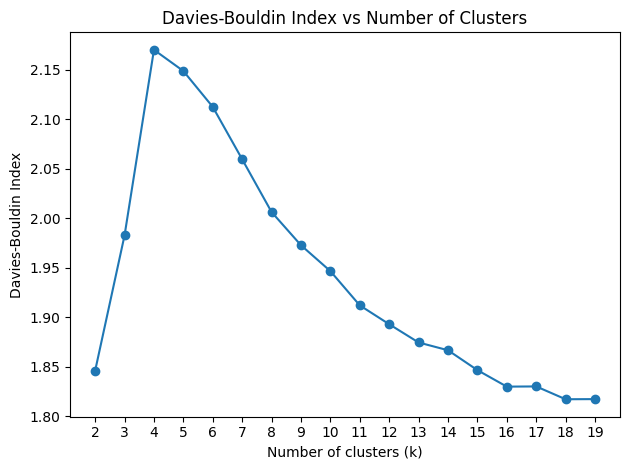

In [15]:
plt.figure()
plt.plot(k_values, davies_bouldin, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.xticks(k_values)
plt.tight_layout()
plt.show()

##### Interpreting the average of fifty random states
Perhaps expectedly, the average results are much more smooth than the single simulation based on the random seed 19. Looking at the results it is hard to conclude whether or not the prior estimate of having 8-10 clusters is a good and representative choice. The sum of the squared errors has a very smooth curve, and finding the elbow seems to very much depend on the amount of clusters chosen to include in the simulation. The silhouette scores and the Davies-Bouldin scores seem to indicate that after the first few clusters 2-4 adding more clusters lead to a continuous decrease of performance. This could indicate that a fewer number of clusters should be used. To test this, we will also continue with 4 clusters as a candidate.

### 3. Train the k-means models
Now, we make a k-means model for every candidate cluster number. In the last section it was found that 8-10 clusters could be a good number of clusters to examine further.

In [16]:
km3  = KMeans(n_clusters=3,  random_state=19)
km4  = KMeans(n_clusters=4,  random_state=19)
km8  = KMeans(n_clusters=8,  random_state=19)
km9  = KMeans(n_clusters=9,  random_state=19)
km10 = KMeans(n_clusters=10, random_state=19)

km3.fit( df_scaled)
km4.fit( df_scaled)
km8.fit( df_scaled)
km9.fit( df_scaled)
km10.fit(df_scaled)

KMeans(n_clusters=10, random_state=19)

### 4. Analyze clusters
Now we take a look at the centroids of the different models.

In [17]:
centers4 = pd.DataFrame(km4.cluster_centers_,columns=df_scaled.columns)
centers_unscaled4 = pd.DataFrame(scaler.inverse_transform(centers4),index=centers4.index,columns=centers4.columns)
centers_unscaled4

,Education,Kidhome,Recency,MntWines,MntFruits,MntSweetProducts,MntGoldProds,NumWebPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Years_customer,Num_AcceptedCmp,MntFishMeatProdcts
0,3.675875,0.053407,71.281768,601.731123,41.066298,48.685083,67.418048,6.268877,8.311234,5.920810,56.808471,9.318600,0.674033,363.112339
1,3.541026,0.684615,50.756410,94.543590,6.843590,7.820513,16.684615,3.415385,3.792308,6.925641,50.830769,8.002564,0.176923,59.043590
2,3.485043,0.044872,25.014957,539.811966,60.401709,53.106838,74.267094,6.344017,8.551282,6.053419,53.972222,8.822650,0.824786,405.326923
3,3.262967,0.813028,47.570567,74.650181,6.446321,7.388420,24.020507,3.745476,3.535585,8.563329,45.436671,9.285887,0.208685,55.724970


In [18]:
centers3 = pd.DataFrame(km3.cluster_centers_,columns=df_scaled.columns)
centers_unscaled3 = pd.DataFrame(scaler.inverse_transform(centers3),index=centers3.index,columns=centers3.columns)
centers_unscaled3

,Education,Kidhome,Recency,MntWines,MntFruits,MntSweetProducts,MntGoldProds,NumWebPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Years_customer,Num_AcceptedCmp,MntFishMeatProdcts
0,3.649329,0.052013,74.600671,537.822148,42.677852,46.704698,66.369128,6.013423,7.907718,5.724832,55.884228,9.077181,0.582215,350.776846
1,3.331502,0.847070,48.392857,59.647436,5.620879,6.134615,18.722527,3.462454,3.370879,8.326007,46.483516,8.897436,0.192308,44.835165
2,3.505535,0.064576,22.761993,539.579336,49.826568,47.841328,69.712177,6.356089,8.359779,6.169742,54.483395,9.007380,0.806273,365.429889


In [19]:
centers3

,Education,Kidhome,Recency,MntWines,MntFruits,MntSweetProducts,MntGoldProds,NumWebPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Years_customer,Num_AcceptedCmp,MntFishMeatProdcts
0,0.662332,0.026007,0.753542,0.360229,0.214462,0.177584,0.183340,0.187919,0.608286,0.286242,0.543350,0.538591,0.116443,0.202652
1,0.582875,0.423535,0.488817,0.039951,0.028246,0.023326,0.051720,0.108202,0.259298,0.416300,0.372428,0.448718,0.038462,0.025397
2,0.626384,0.032288,0.229919,0.361406,0.250385,0.181906,0.192575,0.198628,0.643060,0.308487,0.517880,0.503690,0.161255,0.211141


### 6 - Dimensionality reduction

In [20]:
pca = PCA()
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)

In [21]:
lcolumns = []
for i in range (1,df_scaled.shape[1]+1):
  lcolumns.append('pc' + str(i))
df_pca = pd.DataFrame(df_pca, columns = lcolumns,index=df_scaled.index)
df_pca

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14
0,-0.547178,0.418641,0.067588,-0.101919,-0.130553,0.050737,0.175271,-0.332670,0.255773,-0.009494,0.057807,0.125416,0.043705,0.078977
1,0.539695,-0.431675,-0.055712,-0.024877,-0.233507,0.152497,0.100225,0.022272,0.147185,-0.024340,0.011907,0.044704,0.012377,-0.019845
2,-0.357265,-0.087597,-0.209671,-0.097539,-0.191846,0.003722,-0.151959,0.163413,-0.051420,-0.049455,-0.089043,-0.000298,-0.032422,0.084664
3,0.533591,-0.368754,-0.207595,-0.161738,0.062779,0.089421,-0.042691,0.054502,-0.172307,0.026065,-0.015959,0.048913,-0.043493,0.104770
4,0.257379,-0.444261,0.473951,0.207194,0.299468,0.189488,-0.198370,-0.128107,-0.158211,-0.000510,-0.036117,-0.018997,-0.034611,0.015839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,-0.381655,-0.025824,-0.012213,-0.202693,-0.101045,-0.016166,0.087500,-0.176428,0.114843,0.546196,0.136026,0.190040,-0.172605,-0.080698
2226,0.447251,-0.451212,0.096612,0.480460,0.230636,0.596446,0.137356,0.178453,0.288599,0.014031,0.032032,-0.014501,-0.034533,0.129093
2227,-0.394624,-0.440773,0.395286,-0.260234,0.459858,-0.138592,-0.025630,0.393395,-0.078714,-0.187116,-0.161112,0.008937,-0.013587,-0.173851
2228,-0.300100,-0.638722,-0.355385,0.089563,-0.177004,0.021331,-0.157293,0.164955,0.025703,0.034933,0.006892,-0.008354,0.031095,0.033107


<Axes: xlabel='pc1', ylabel='pc2'>

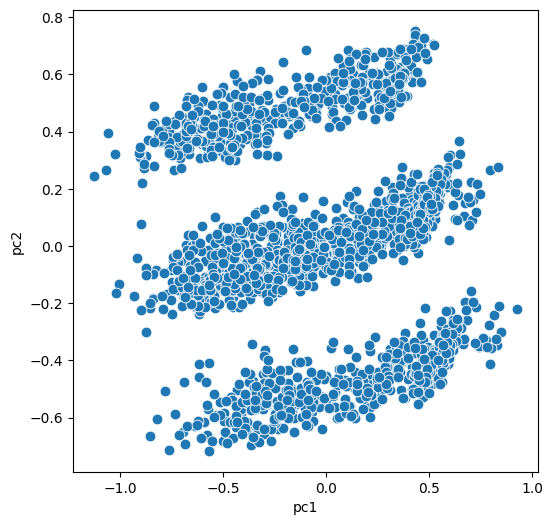

In [ ]:
plt.figure(figsize=(6,6))
sns.scatterplot( x='pc1', y='pc2',s=60,
  data=df_pca,legend=True)

#### t-SNE
Applying t-SNE to the data set is helpful to visualize clusterings in the data. The algorithm attempts to project higher dimensional data into lower dimention space. In short, the algorithm tries to make sure that points that are close together in the high dimensional space remain close together in the low-dimension projection. However, the actual structure of the data is not retained, so it is not possible to say anything meaningful about the actual distances between points based on the t-SNE projection. The projection is more useful to visualize clustering in the data.

The algorithm depends on a hyperparameter called perplexity, which is a number that states how many of the nearby points a given point should consider when modelling proximity. A lower hyperparameter is better at capturing local patterns, whereas a larger value can capture more global groupings.

In [56]:
tsne = TSNE()
df_tsne = tsne.fit_transform(df_scaled)
dicc_tsne = {'comp_1':df_tsne[:,0],'comp_2':df_tsne[:,1]}
df_tsne = pd.DataFrame(dicc_tsne,index=df_scaled.index)

<Axes: xlabel='comp_1', ylabel='comp_2'>

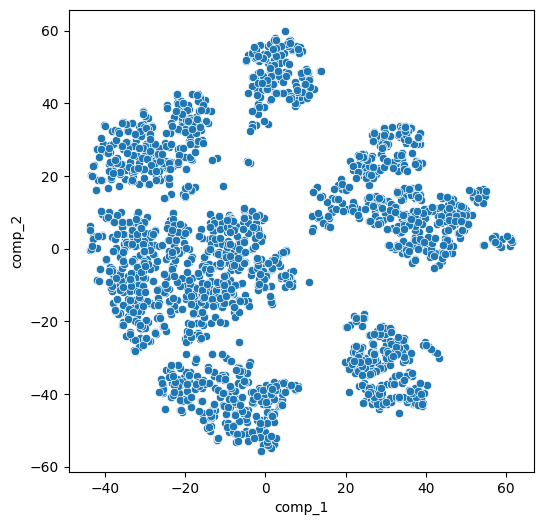

In [57]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=df_tsne, x='comp_1',y='comp_2', legend='full')

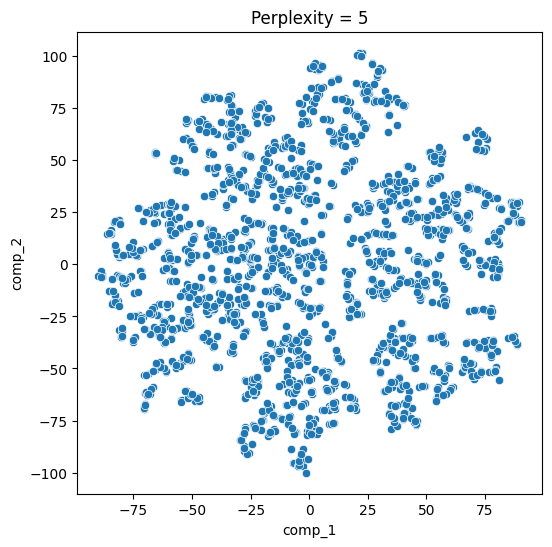

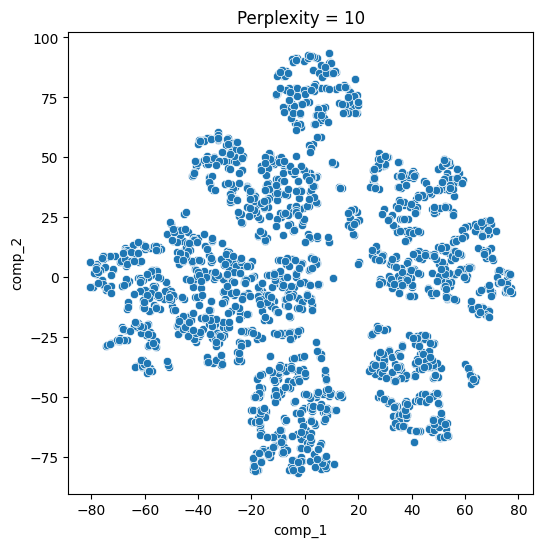

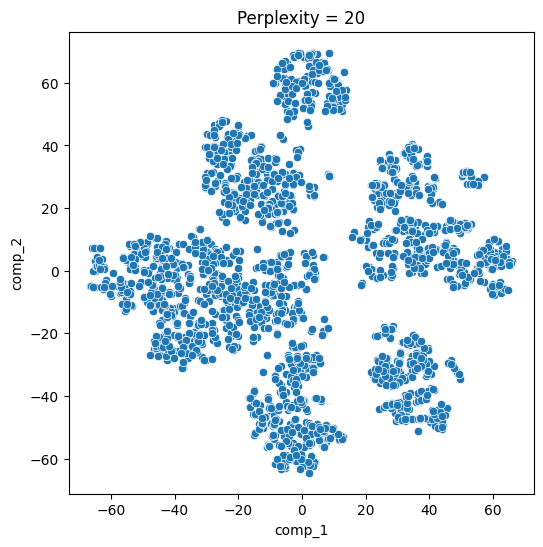

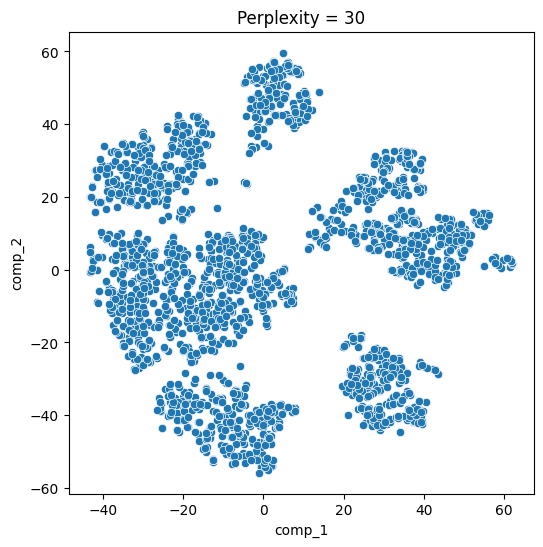

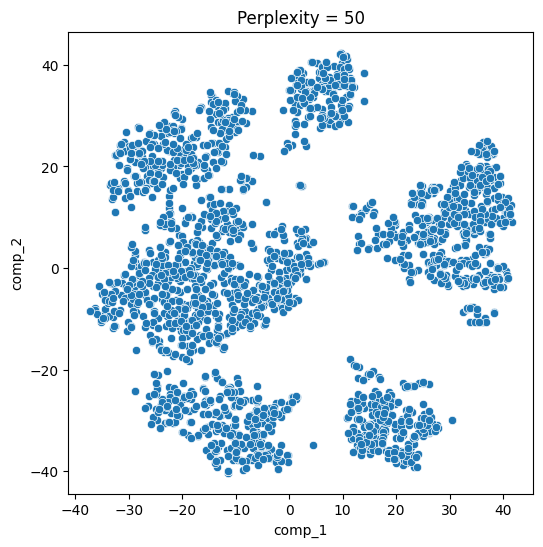

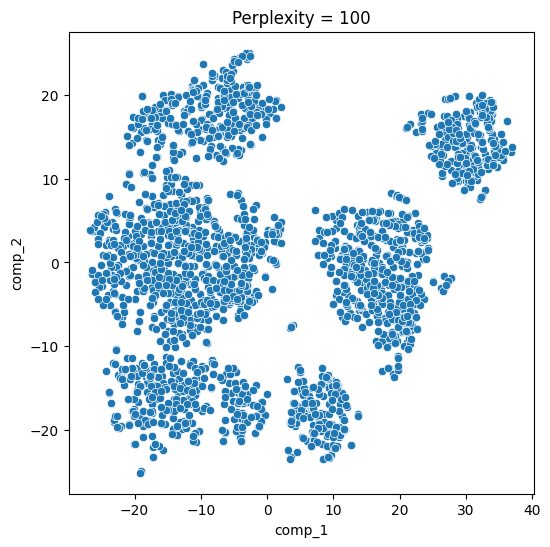

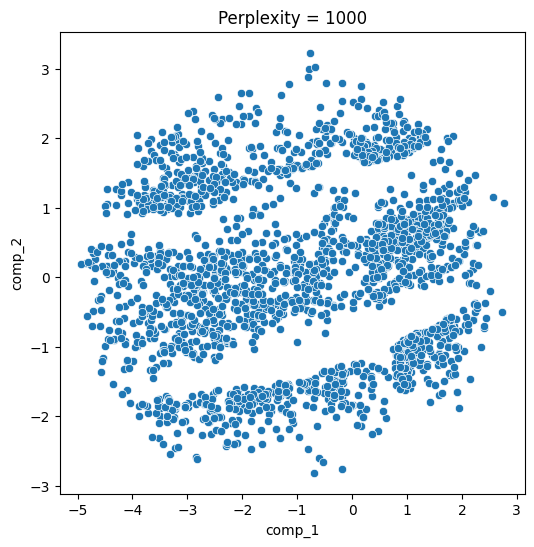

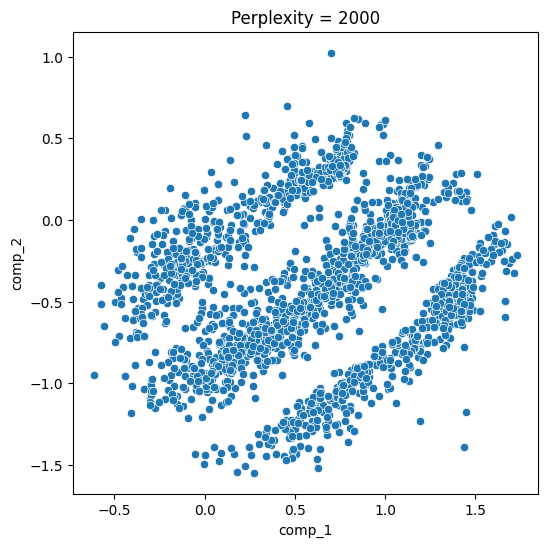

In [59]:
for perp in [5,10,20,30,50,100,1000,2000]:
  tsne = TSNE(perplexity=perp,random_state=72)
  X_tsne = tsne.fit_transform(df_scaled)
  dicc_tsne = {'comp_1':X_tsne[:,0],'comp_2':X_tsne[:,1]}
  df_tsne = pd.DataFrame(dicc_tsne,index=df_scaled.index)
  plt.figure(figsize=(6,6))
  plt.title('Perplexity = ' + str(perp))
  sns.scatterplot(data=df_tsne, x='comp_1',y='comp_2', legend='full')

#### Check if the data requires some preprocessing. At the very least, you should have the data scaled for k-means and PCA. Take into account that you can always unscale the data for better interpretation of the results.


In [1]:
import pandas as pd

df = pd.read_csv("customer_data_large.csv")


print(df.head())  
print(df.info())
print(df.isnull().sum())
print(df.describe()) 

   Education  Kidhome  Recency  MntWines  MntFruits  MntSweetProducts  \
0          3        0       58       635         88                88   
1          3        1       38        11          1                 1   
2          3        0       26       426         49                21   
3          3        1       26        11          4                 3   
4          5        1       94       173         43                27   

   MntGoldProds  NumWebPurchases  NumStorePurchases  NumWebVisitsMonth  Age  \
0            88                8                  4                  7   65   
1             6                1                  2                  5   63   
2            42                8                 10                  4   57   
3             5                7                  4                  6   38   
4            15                5                  6                  5   41   

   Years_customer  Num_AcceptedCmp  MntFishMeatProdcts  
0              10            

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

nimaScaler = MinMaxScaler()
scaler = StandardScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_nima_scaled = pd.DataFrame(nimaScaler.fit_transform(df), columns=df.columns)

print(df_scaled.head())

   Education   Kidhome   Recency  MntWines  MntFruits  MntSweetProducts  \
0  -0.457341 -0.825281  0.305096  0.982341   1.554427          1.473303   
1  -0.457341  1.031809 -0.385769 -0.870089  -0.636292         -0.631912   
2  -0.457341 -0.825281 -0.800288  0.361896   0.572380         -0.147954   
3  -0.457341  1.031809 -0.800288 -0.870089  -0.560750         -0.583516   
4   1.536541  1.031809  1.548652 -0.389170   0.421296         -0.002767   

   MntGoldProds  NumWebPurchases  NumStorePurchases  NumWebVisitsMonth  \
0      0.850944         1.028070          -0.551928          -0.026234   
1     -0.729510        -1.254743          -1.166559          -0.517841   
2     -0.035652         1.028070           1.291966          -0.763645   
3     -0.748784         0.701954          -0.551928          -0.272038   
4     -0.556046         0.049722           0.062703          -0.517841   

        Age  Years_customer  Num_AcceptedCmp  MntFishMeatProdcts  
0  1.292790        1.503387         0

In [3]:
from sklearn.cluster import KMeans

km_model = KMeans(n_clusters=4,random_state=3)
km_model.fit(df_nima_scaled)

KMeans(n_clusters=4, random_state=3)

In [4]:
centers = pd.DataFrame(km_model.cluster_centers_,columns=df_nima_scaled.columns)

centers

,Education,Kidhome,Recency,MntWines,MntFruits,MntSweetProducts,MntGoldProds,NumWebPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Years_customer,Num_AcceptedCmp,MntFishMeatProdcts
0,0.601764,0.516282,0.490756,0.041300,0.026776,0.023232,0.046583,0.108887,0.265212,0.418182,0.368916,0.322252,0.035550,0.023669
1,0.517405,0.292722,0.463943,0.077295,0.051778,0.042728,0.093958,0.141119,0.309396,0.458861,0.357135,0.939873,0.063924,0.053920
2,0.667125,0.002747,0.548378,0.205933,0.111289,0.088720,0.123110,0.149725,0.463088,0.254670,0.554812,0.279304,0.056777,0.110664
3,0.633122,0.033281,0.475132,0.454680,0.313015,0.239050,0.220101,0.207954,0.710228,0.317195,0.512750,0.629160,0.192393,0.266318


# t-SNE

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
#columns_names = ["Education", "Kidhome", "Recency", "MntWines", "MntFruits", "MntSweetProducts", "MntGoldProds", "NumWebPurchases", "NumStorePurchases", "NumWebVisitsMonth", "Age", "Years_customer", "Num_AcceptedCmp", "MntFishMeatProdcts"]
df_customers = pd.read_csv('customer_data_large.csv')

In [29]:
tsne = TSNE()
X_tsne = tsne.fit_transform(df_customers)

In [ ]:
dicc_tsne = {'comp_1':X_tsne[:,0],'comp_2':X_tsne[:,1]}
df_tsne = pd.DataFrame(dicc_tsne,index=df_customers.index)

<Axes: xlabel='comp_1', ylabel='comp_2'>

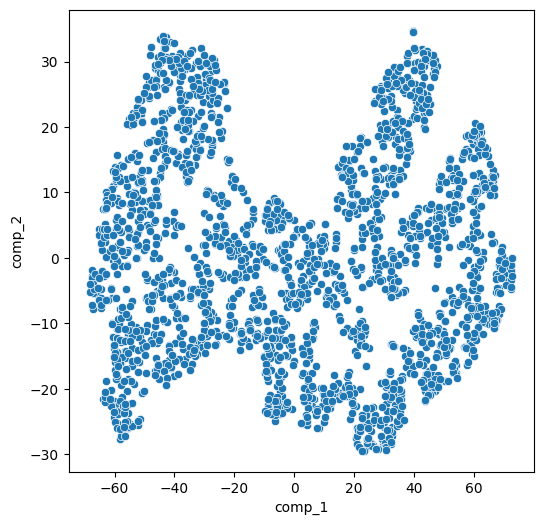

In [32]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=df_tsne, x='comp_1',y='comp_2', legend='full')

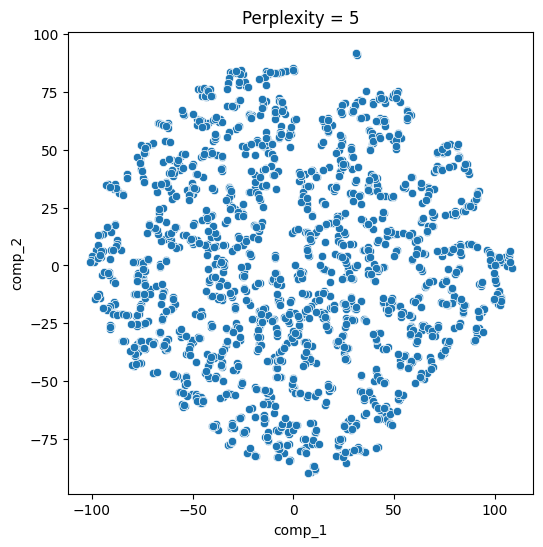

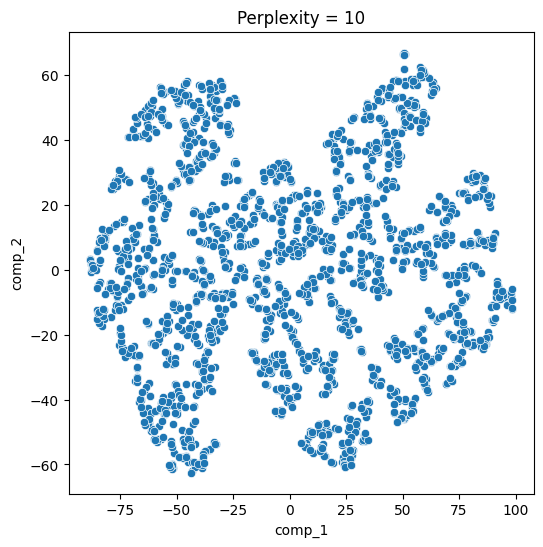

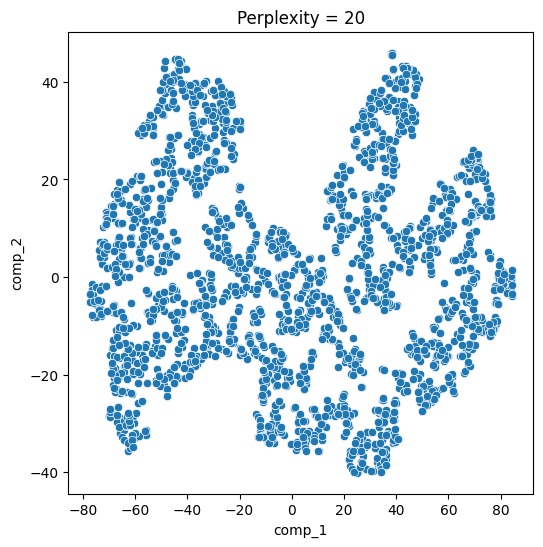

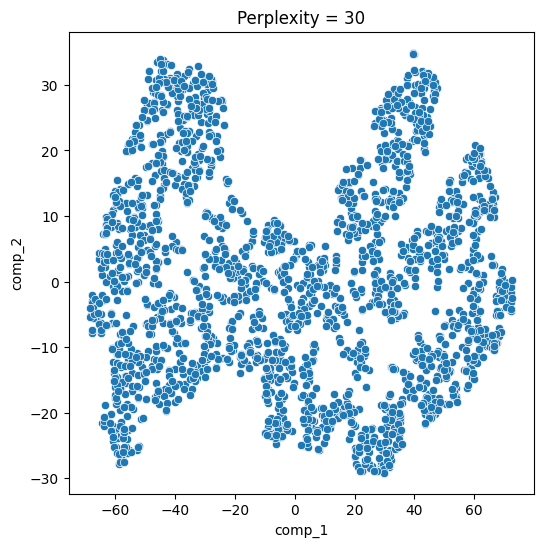

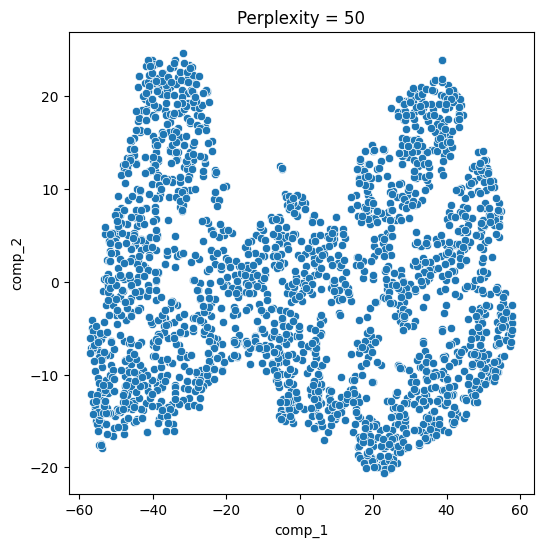

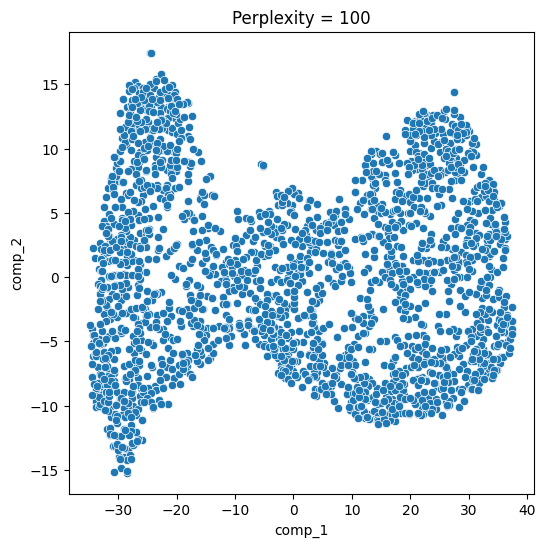

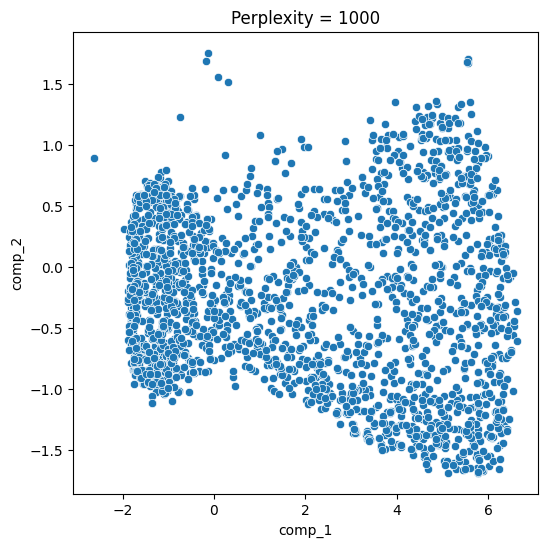

In [35]:
for perp in [5,10,20,30,50,100,1000]:
  tsne = TSNE(perplexity=perp,random_state=72)
  X_tsne = tsne.fit_transform(df_customers)
  dicc_tsne = {'comp_1':X_tsne[:,0],'comp_2':X_tsne[:,1]}
  df_tsne = pd.DataFrame(dicc_tsne,index=df_customers.index)
  plt.figure(figsize=(6,6))
  plt.title('Perplexity = ' + str(perp))
  sns.scatterplot(data=df_tsne, x='comp_1',y='comp_2', legend='full')